# nbed library: Peak detection example
L. Houben, Weizmann Institute of Science
last updated January 2026

- Load a 4D STEM nanobeam diffraction data set.
  This script uses a data set that can be downloaded from https://doi.org/10.5281/zenodo.15212905
- Inspect a frame.
- Bin the data for faster processing
- Compensate residual descan shifts.
- Adjust peak detection parameters in a subset of frames.
- Run peak detection on all frames.
- Create a Debye-Scherrer type plot
- Create a peak distance histogram ('powder plot')

In [67]:
import numpy as np
import numpy.matlib
#from objbrowser import browse
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pims
import trackpy as tp
# for animated view
import time
from IPython import display
%matplotlib inline
import os
# load nbed module and helper routines
# possibly installed under miniforge3/envs/py4Dstem/lib/python3.9/site-packages
import nbed
from nbed import ParabolaFit2D,bytscl

## Define filename, create class instance, load the data set, and display a single frame 
Currently supported formats: 
- PantaRhei .prz (default)
- EMPAD .raw

In [73]:
# Path definition and filename
path="/Users/houben/Downloads/"
filebasename="Coccolithophore0025"
filesuffix="prz"
# binning factors
sbin=1 # spatial binning
qbin=1 # diffraction frame binning

In [69]:
# create an instance of the pyNBED module and load data
myset=nbed.pyNBED()
myset.LoadFile(path+filebasename+'.'+filesuffix)

pyNBED: Loading object descriptor: /Users/houben/Downloads/Coccolithophore0025.prz
pyNBED: Loading data ...
        finished
pyNBED: array dimensions: (217, 256, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


In [70]:
# There is a docstring for the methods in the pyNBED module, here is how you can display it
myset.LoadFile?

Signature: myset.LoadFile(fname, type='PantaRhei')
Docstring:
Load a 4D STEM dataset  

Parameters:
fname:   complete filename including path and suffix
type:    'PantaRhei' or 'EMPAD' [default: PantaRhei]

Returns:

void
File:      ~/miniforge3/envs/py4dstem/lib/python3.12/site-packages/nbed/classes/pyNBED.py
Type:      method

frame coordinates: 174 94
frame dimensions:  (256, 256)


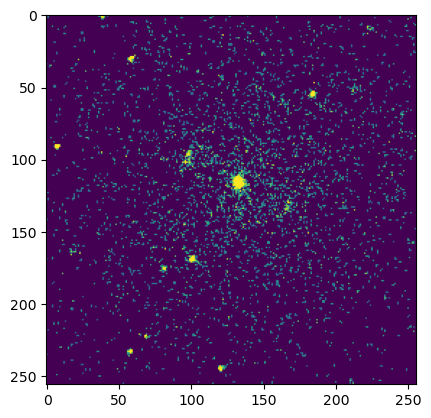

In [71]:
# Display a single frame at row 174, column 94
frame=myset.ShowFrame(i=174, j=94,Log=True, sd=6)

In [74]:
### Spatial Binning
myset.SpatialBinning?

Signature: myset.SpatialBinning(bin)
Docstring:
Spatial Binning

Binning of the first two dimensions x,y of the 4D STEM data (x,y,qx,qy)

Parameters:
bin:   binning factor (default: 2)

returns

nothing (the object data will be replaced)
File:      ~/miniforge3/envs/py4dstem/lib/python3.12/site-packages/nbed/classes/pyNBED.py
Type:      method

In [75]:
# Spatial Binning
if sbin > 1:
    myset.SpatialBinning(bin=sbin)

In [76]:
# Diffraction Frame Binning
if qbin > 1:
    myset.FrameBinning(bin=2)

## Find central diffraction peak locations and compensate the displacement
The data held by the class instance will be updated and hold the aligned frames. <br>
A second execution will display the residual displacements after correction with a second order polynomial.

locating strongest pixel in all frames ...
finished


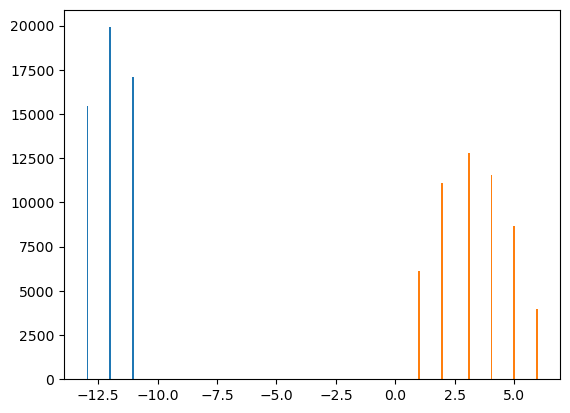

Displacement statistics along x, filtered for outliers (all indices):
Mean =  -11.971085213464224 ( -11.956221198156681 )
Max  =  -11 ( -9 )
Min  =  -13 ( -14 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  3.3016820713014523 ( 3.264832949308756 )
Max  =  6 ( 7 )
Min  =  1 ( 0 )


<Figure size 640x480 with 0 Axes>

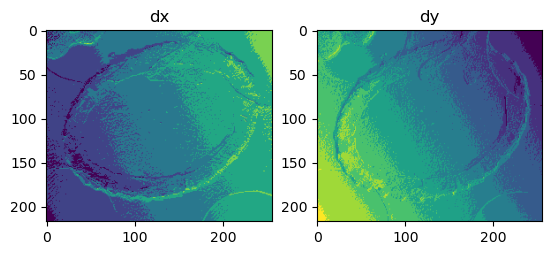

In [77]:
# obtain displacements
(dx,dy)=myset.DiffractionShift(reject_sd=2, searchradius=20)

(55552,)


<Figure size 640x480 with 0 Axes>

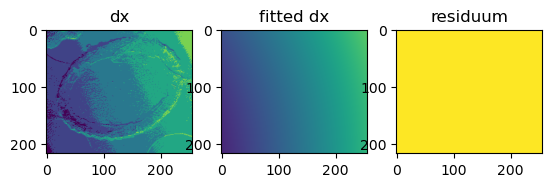

Residuum statistics dx-dxfit
Mean deviation:     2.686023446673766e-16
Max abs deviation:  3.4564934238318887
Mean abs deviation: 0.3370847595316985
(55552,)


<Figure size 640x480 with 0 Axes>

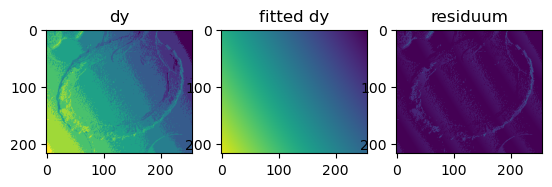

Residuum statistics dy-dyfit
Mean deviation:     -5.833535748670101e-10
Max abs deviation:  2.7902017276734163
Mean abs deviation: 0.35053075660262695
finished


In [78]:
# compensate shifts pixel-wise
myset.CompensateShift(dx,dy)

locating strongest pixel in all frames ...
finished


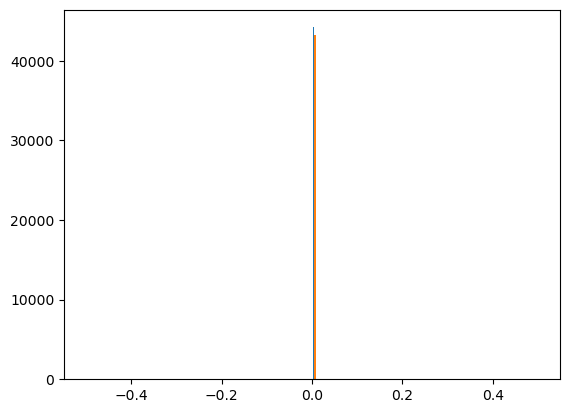

Displacement statistics along x, filtered for outliers (all indices):
Mean =  0.0 ( 0.007848502304147466 )
Max  =  0 ( 3 )
Min  =  0 ( -3 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  0.0 ( 0.002376152073732719 )
Max  =  0 ( 3 )
Min  =  0 ( -3 )


<Figure size 640x480 with 0 Axes>

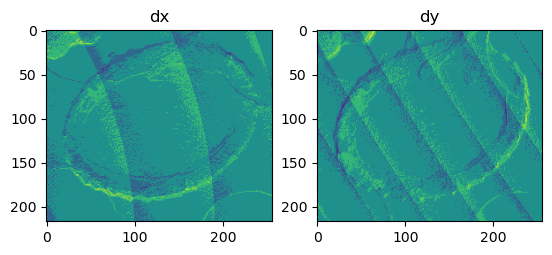

In [79]:
# check that the correction worked and display the residual displacement statistics 
# the residuum shows the com shift corrected for the low-order descan shift
# steps in the residuum are integer truncation remainders due to the pixel-wise shift
(dx,dy)=myset.DiffractionShift(reject_sd=2, searchradius=20)

## Create a virtual aperture image



In [80]:
# Create a virtual detector image
# this may take some time due to single-core processing
# the routine returns the mask on the diffraction frame and the corresponding virtual image
myset.VirtualApertureImage?

Signature:
myset.VirtualApertureImage(
    radius=[0, 10],
    offset=None,
    invert=False,
    mode=None,
)
Docstring:
Create a virtual detector image with a disk-like aperture

Parameters:
radius:    inner and outer radius of the aperture in pixels [default:[0,10]]
offset:    optional displacement from the center in pixels [default: None]
           offset=[20,100] shifts the aperture mask 20 pixels horizontally and 100 pixels vertically
invert:    invert the aperture mask, e.g. to create a dark-field image instead of a bright-field image
mode:      calculation mode, default is 'sum', options: 'sum','fluct','fluct_norm'
           'fluct'=variance across the mask, 'fluct_norm'=variance divided by mean value
   
Notes: 

the mask will span the range [iradius,oradius[
the computational effort is proportional to the number of pixels in the mask

Examples: 

BF detector - radius=[0,radius] of the bright field mask, invert=False
DF detector - radius=[0,100], invert=True
annular DF detec

In [81]:
# create a virtual detector image, here an annular dark-field image
(mask, vimage)=myset.VirtualApertureImage(radius=[70//qbin,100//qbin],offset=[0,0],invert=False,mode='sum')

/Users/houben/miniforge3/envs/py4dstem/lib/python3.12/site-packages/nbed/helpers.py:105: RuntimeWarning: invalid value encountered in cast
  img8bit[img < vmin]=vmin


<Figure size 640x480 with 0 Axes>

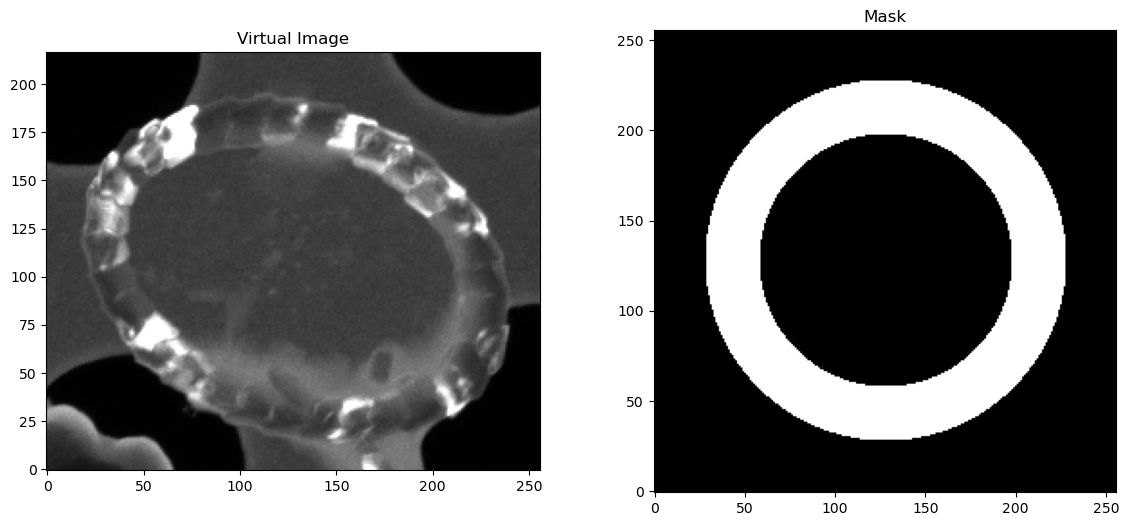

In [82]:
# plot the image
#dispimage=np.log(vimage)
dispimage=vimage
plt.figure()
#subplot(r,c) provide the no. of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax1.imshow(bytscl(dispimage,vmin=np.mean(dispimage)-3*np.std(dispimage),vmax=np.mean(dispimage)+3*np.std(dispimage)),cmap='gray',origin="lower") 
ax1.set_title('Virtual Image')
ax2.imshow(mask,cmap='gray',origin="lower")
ax2.set_title('Mask')
plt.show()

## Preparation Step for the Peak Detection
Prepare a preset for the detection parameters.
These parameters are detector-dependent, nbed has presets for DECTRIS counting detectors and the EMPAD detector.

In [83]:
# retrieve default peak detection parameters for the Dectris ELA detector 
pars=myset.PreparePeakDetectionPars(shortcut='ELA')

In [84]:
# report parameters
for key,value in pars.items():
    print(key,": ", value)

feature_size :  7
feature_minmass :  2.0
feature_separation :  8
feature_percentile :  65.0
feature_threshold :  1.0
noise_size :  1.0
smooth_size :  None
frame_cmin :  1.0
frame_cmax :  10.0
frame_cutoff :  0.0
conv2D :  True


In [85]:
# adapt parameters, setting conv2D to False speeds up processing
pars["feature_minmass"]=10
pars["feature_threshold"]=2*sbin**2
pars["conv2D"]=False
pars["frame_cmax"]=10.

## Peak detection
Detect peaks in a sub-region. The peak detection method uses a 1D index array for addressing the spatial pixels. The method LinearIndexArray converts the 2D coordinate ranges into a 1D array. 

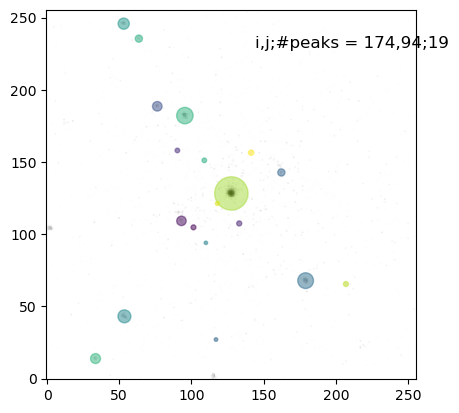

In [86]:
# define region of interest - columns=horizontal axis, rows=vertical axis
rows=np.arange(170//sbin,175//sbin)
cols=np.arange(90//sbin,95//sbin)
# Linearize frame indices
indcs=myset.LinearIndexArray(rows,cols,is_roi=True)
# detect peaks in region of interest
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=True)

Detect peaks in the full frame. Skip graphical output.

In [87]:
# run peak search on all frames
# this may take a little while
rows=np.arange(0,myset.dim[0])
cols=np.arange(0,myset.dim[1])
indcs=myset.LinearIndexArray(rows,cols,is_roi=True)
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=False)

Processing Frames : 100%|██████████████████████████████████| 55552/55552 [08:11<00:00, 113.05it/s]


In [88]:
# The peaklist is an array of dictionaries
# show the peak data for the frame at coordinate (167,96) in the original, unbinned sampling frame
# peak coordinates are in pixel units
i=167//sbin
j=96//sbin
frameno=i*myset.dim[1]+j
framepeaklist[frameno]

{'i': 167,
 'j': 96,
 'x': array([   0.35670285,   10.36046512,   -6.63380282,    4.17073171,
         -10.12676056,  -27.2       ,   17.        ,  -16.72727273,
         -33.79166667,  -35.08152174,   35.        ,    0.78723404,
         -44.02439024,  -48.        ,   54.0754717 ,    0.60526316,
         -37.        ,  -24.90909091,   15.77027027,   21.        ,
          51.39473684,   20.        ,  -50.496     ,   51.70898204,
          98.        ,  -73.50359712, -112.38333333, -124.84984985,
         -74.33333333]),
 'y': array([ -0.77911411,  -6.65116279, -12.43661972,  15.02439024,
        -23.66197183,  -2.78181818, -23.        ,  25.        ,
          3.10416667, -13.0923913 ,  15.21917808, -39.21276596,
         14.        , -24.        ,  -5.30188679, -55.78947368,
         43.        ,  57.93506494,  61.43243243, -65.        ,
         50.18421053, -73.        ,  59.472     , -61.21077844,
         48.        , -85.53956835,  47.98333333, -24.78378378,
        117.39377289

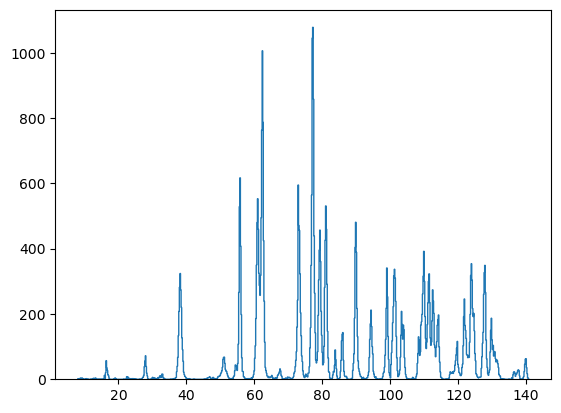

In [89]:
# produce a peak distance histogram - a type of powder diffraction - from all frames
# filter peaks with a raw electron count >= 200
# refine the center for each frame, this produces the sub-pixel precision
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=True, massthresh=200,qrange=[0,140//qbin])

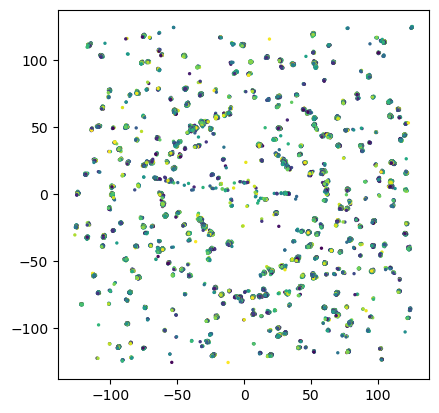

In [91]:
# produce a scatterplot - Debye-Scherrer plot - from all frames
# filter peaks with a raw electron count >= 200
# refine the center for each frame, this produces the sub-pixel precision
(qx,qy)=myset.DebyeScherrerPlot(framepeaklist, refine=True, massthresh=200)

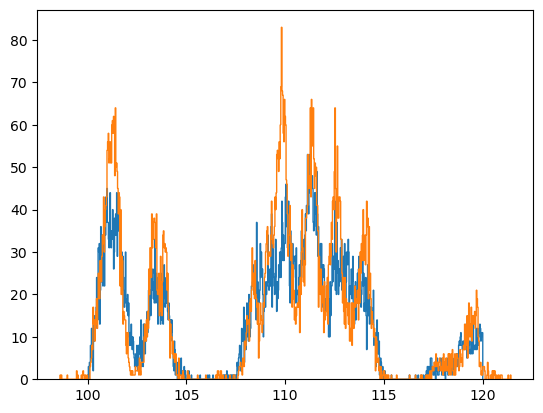

In [92]:
# produce a peak distance histogram
# filter peaks with a raw electron count >= 200
# compare refined and non-refined data at the large angles, note the subpixel precision
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=False, massthresh=200,qrange=[100//sbin,120//sbin])
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=True, massthresh=200,qrange=[100/sbin, 120//sbin])